Data Cleaning

In [3]:
import pandas as pd
import numpy as np

#Stream loading the dataset to avoid memory errors
chunksize = 500_000
clean_chunks = []

for chunk in pd.read_csv("2019-Oct.csv", chunksize=chunksize):
    #Dropping rows that has null values or is missing
    chunk = chunk.dropna(subset=["event_type", "product_id", "price"])

    #fixing datatypes
    chunk["price"] = pd.to_numeric(chunk["price"], errors="coerce")
    chunk["event_time"] = pd.to_datetime(chunk["event_time"], errors="coerce")

    #Dropping invalid prices
    chunk = chunk[(chunk["price"] > 0) & (chunk["price"] < 20000)]

    #Filling the category
    chunk["category_code"] = chunk["category_code"].fillna("unknown")
    chunk["brand"] = chunk["brand"].fillna("unknown")

    #Dropping duplicate rows
    chunk = chunk.drop_duplicates()

    #Converting to categorical cols
    chunk["event_type"] = chunk["event_type"].astype("category")
    chunk["brand"] = chunk["brand"].astype("category")
    clean_chunks.append(chunk)

#Combining and exporting the cleaned data to ecommerce_cleaned.csv
df = pd.concat(clean_chunks, ignore_index=True)
df.to_csv("ecommerce_cleaned.csv", index=False)

print("Cleaned dataset saved: ecommerce_cleaned.csv")
print("Rows:", len(df), "| Columns:", len(df.columns))
print(df.dtypes)

Cleaned dataset saved: ecommerce_cleaned.csv
Rows: 42349875 | Columns: 9
event_time       datetime64[ns, UTC]
event_type                  category
product_id                     int64
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
dtype: object


Local EDA

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Loading the cleaned dataset
df = pd.read_csv("ecommerce_cleaned.csv")
print("Data Loaded:", df.shape)
df.head()


Data Loaded: (42349875, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,unknown,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,unknown,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [6]:
print("Basic info:")
df.info()

print("\nMissing values:")
print(df.isna().sum())

print("\nSummary statistics:")
print(df.describe(include='all'))

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42349875 entries, 0 to 42349874
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB

Missing values:
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     2
dtype: int64

Summary statistics:
                       event_time event_type    product_id   category_id  \
count                    42349875   42349875  4.234988e+07  4.234988e+07   
unique                    2621376          3           NaN           NaN   
top     2019-10-15 08:52:00+00:00       view          

Number of rows in 2019-OCT.csv dataset = 42349875 entries
Number of columns in 2019-OCT.csv dataset = 9
For non-null counts -> user_session has 2 null entries
From the price column, We noticed
mean = 2.907840e+02
minimum value = 7.700000e-01
maximum value = 2.574070e+03

C:\Users\harsh\AppData\Local\Temp\ipykernel_26812\991685402.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='event_type', data=df, palette='Set2')


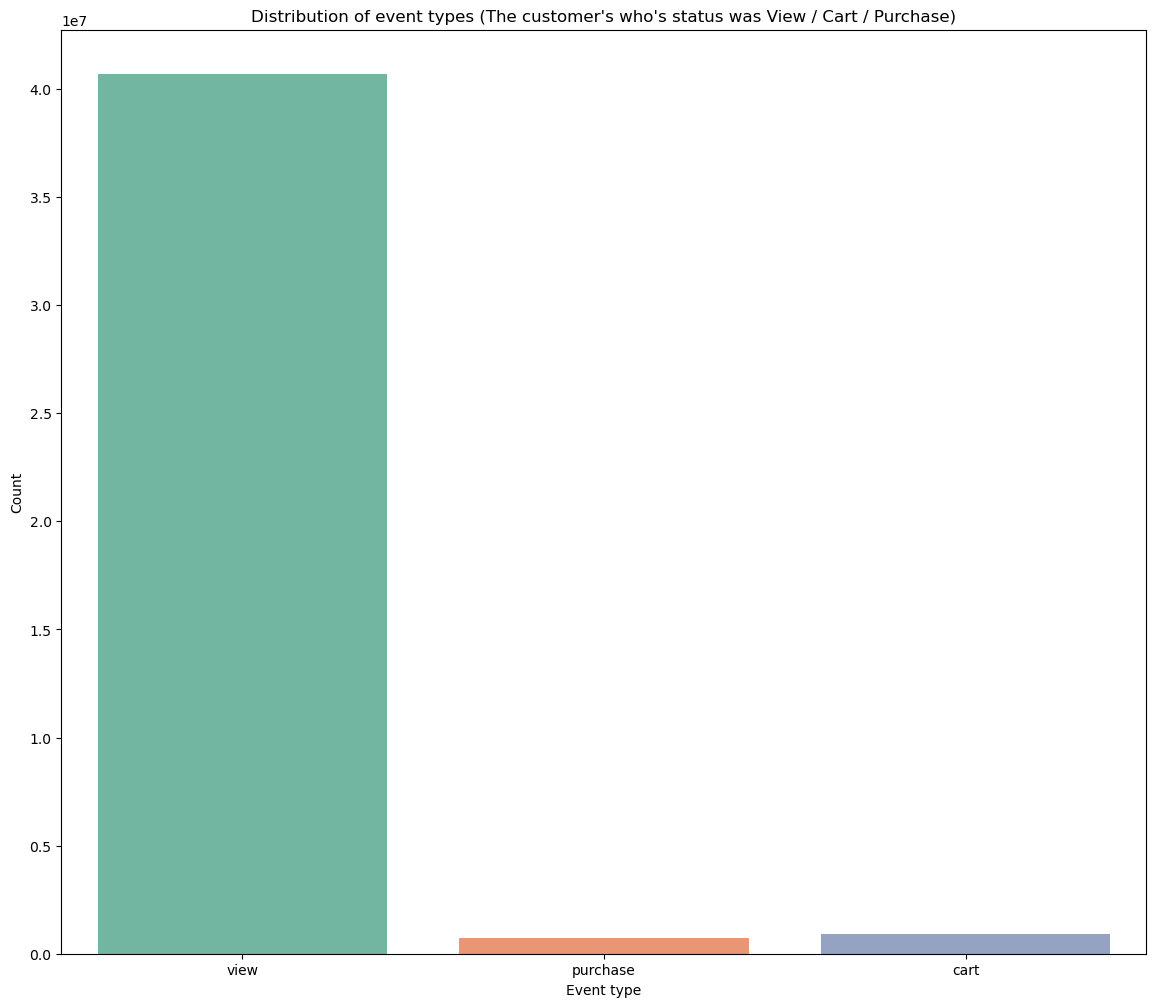

In [8]:
plt.figure(figsize=(14,12))
sns.countplot(x='event_type', data=df, palette='Set2')
plt.title("Distribution of event types (The customer's who's status was View / Cart / Purchase)")
plt.xlabel("Event type")
plt.ylabel("Count")
plt.show()

Most user actions are product views, followed by “add to cart” and few purchases — typical conversion funnel.

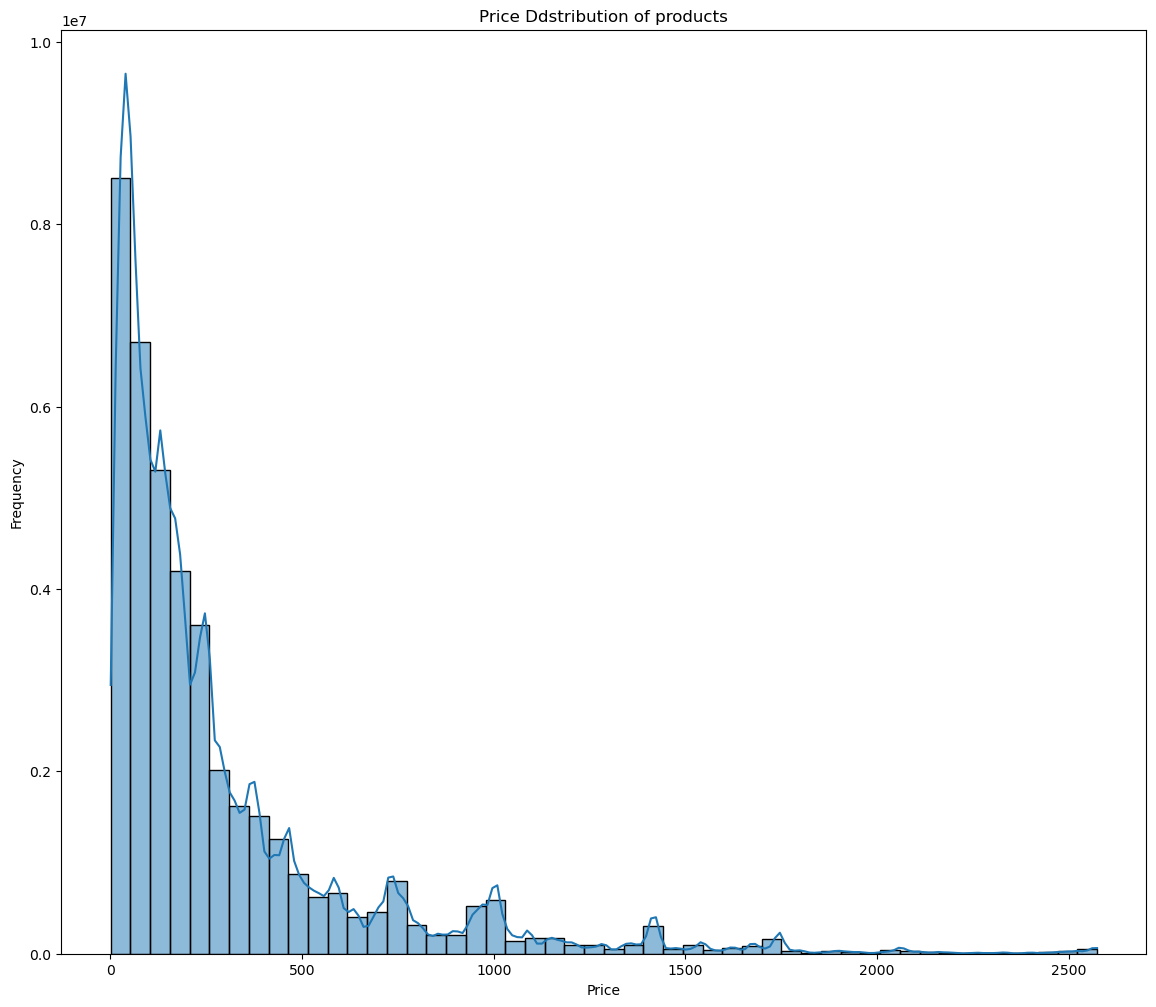

In [10]:
plt.figure(figsize=(14,12))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Ddstribution of products")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

Price follows a right-skewed distribution → majority of items are low-priced, few high-end outliers.

Top 10 Product Categories by Purchases

C:\Users\harsh\AppData\Local\Temp\ipykernel_26812\1833914014.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette='cool')


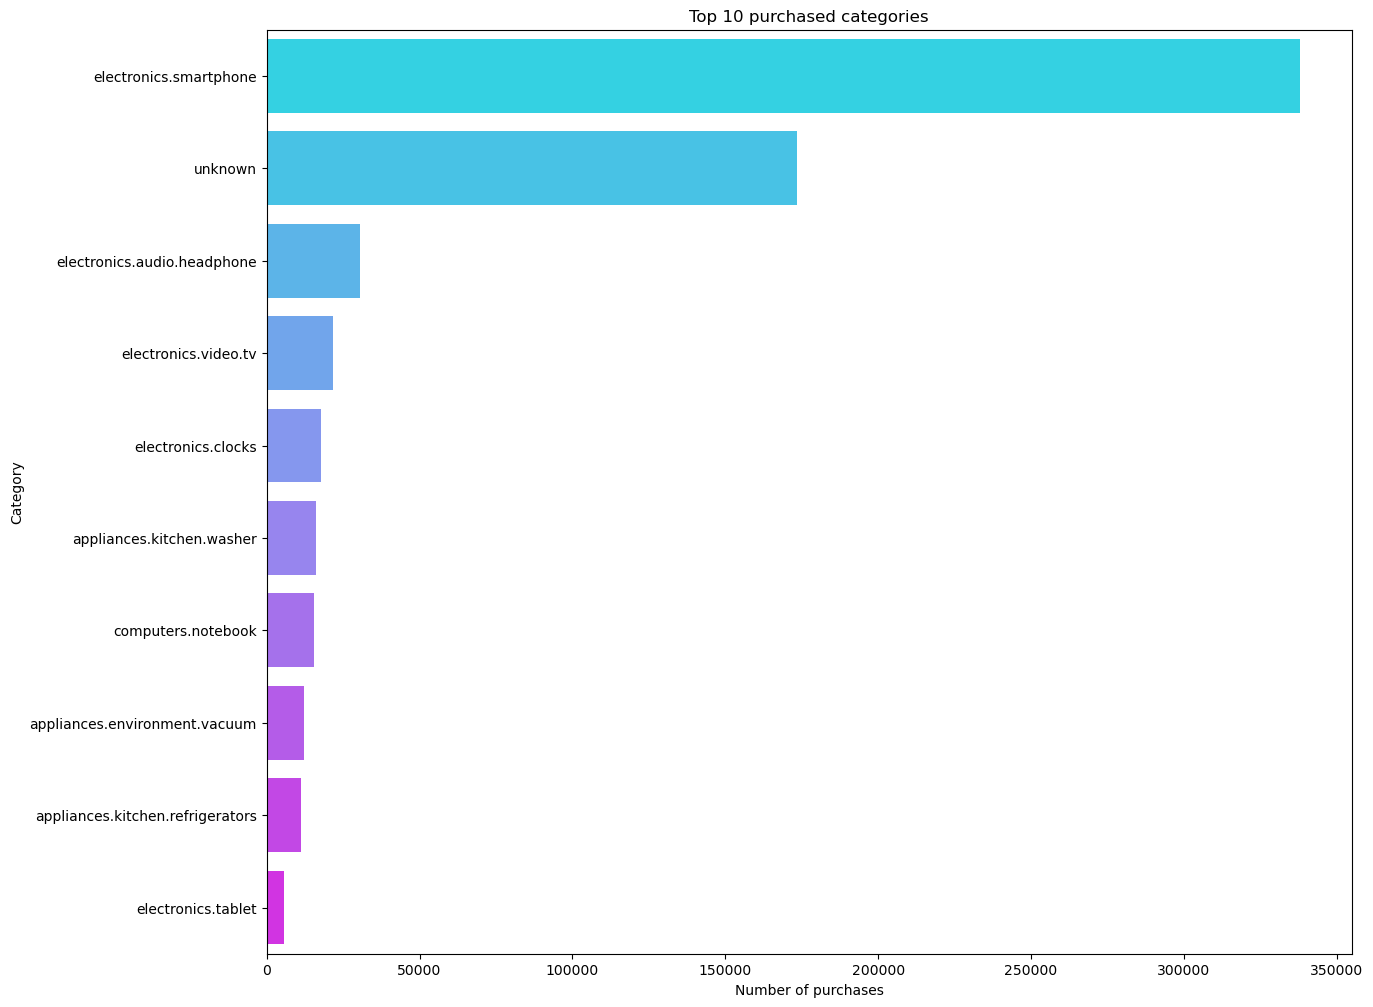

In [13]:
purchase_df = df[df['event_type'] == 'purchase']
top_cats = (purchase_df['category_code'].value_counts().head(10))

plt.figure(figsize=(14,12))
sns.barplot(x=top_cats.values, y=top_cats.index, palette='cool')
plt.title("Top 10 purchased categories")
plt.xlabel("Number of purchases")
plt.ylabel("Category")
plt.show()

Electronics and smartphones dominate sales, followed by apparel and accessories categories.

Top 10 Brands by Total Purchases

C:\Users\harsh\AppData\Local\Temp\ipykernel_26812\2905220162.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')


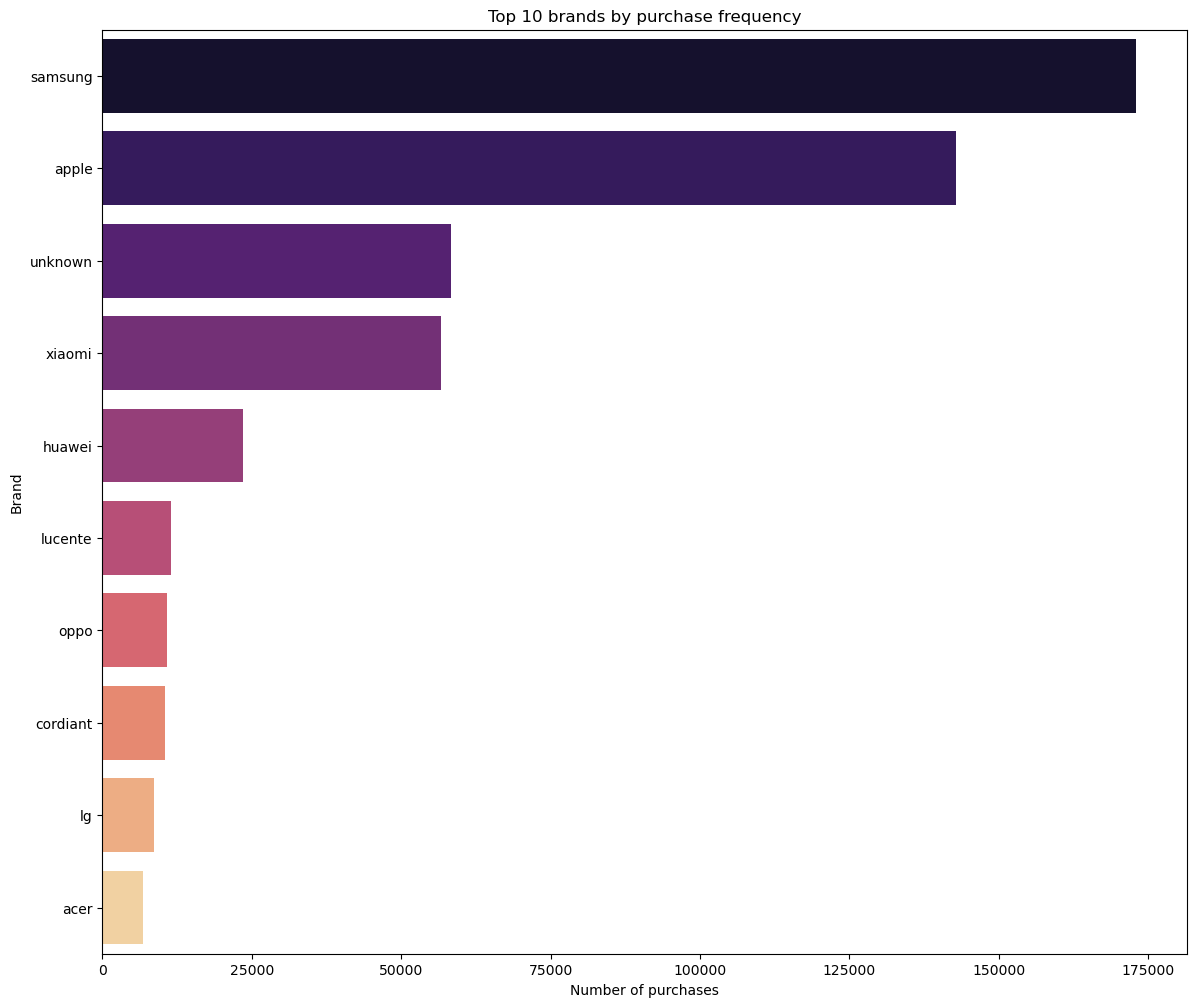

In [16]:
top_brands = (purchase_df['brand'].value_counts().head(10))

plt.figure(figsize=(14,12))
sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')
plt.title("Top 10 brands by purchase frequency")
plt.xlabel("Number of purchases")
plt.ylabel("Brand")
plt.show()

Brands like Xiaomi, Samsung, Apple appear consistently in the top list — clear brand loyalty.

Hourly Activity Trend

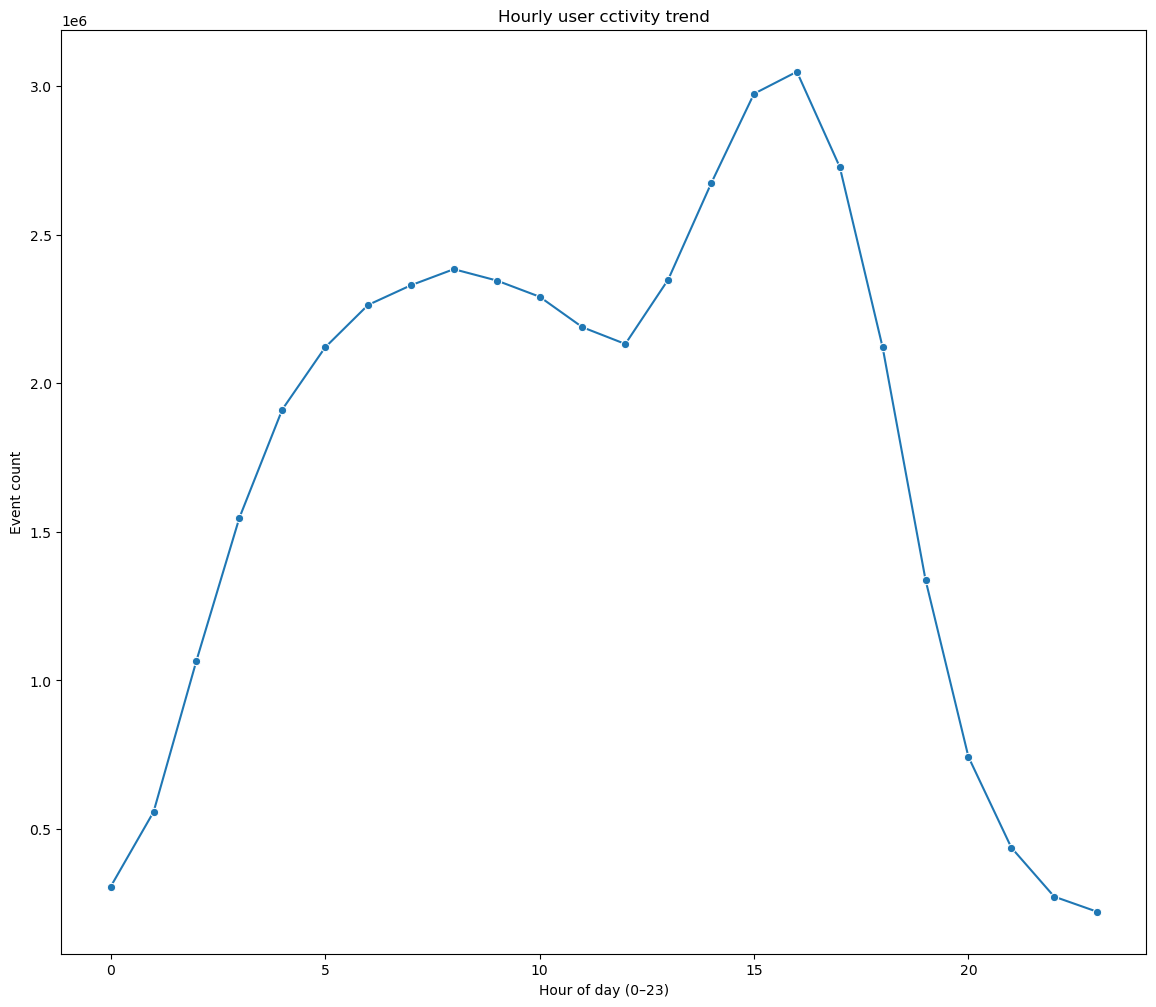

In [19]:
df['hour'] = pd.to_datetime(df['event_time']).dt.hour
hourly = df['hour'].value_counts().sort_index()

plt.figure(figsize=(14,12))
sns.lineplot(x=hourly.index, y=hourly.values, marker='o')
plt.title("Hourly user cctivity trend")
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Event count")
plt.show()

User activity peaks during evenings (18:00 – 22:00 UTC), aligning with after-work shopping hours.

Conversion rate by category

C:\Users\harsh\AppData\Local\Temp\ipykernel_26812\2377737602.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_conversion.values, y=top_conversion.index, palette='Blues_r')


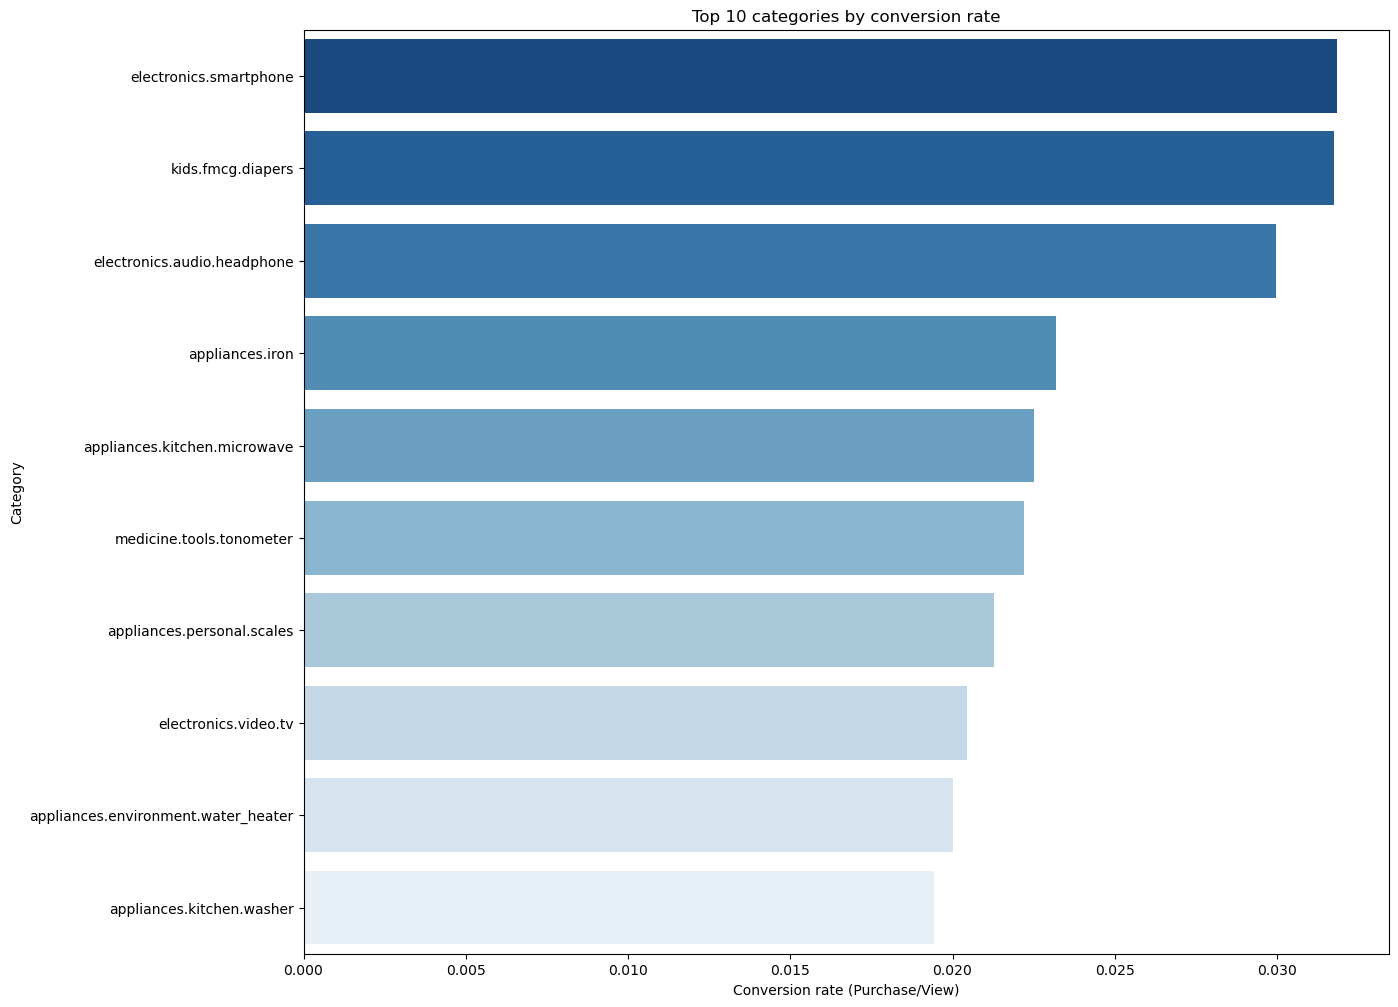

In [22]:
conversion = (df.groupby("category_code")["event_type"].value_counts().unstack().fillna(0))
conversion["conversion_rate"] = conversion["purchase"] / conversion["view"]
top_conversion = conversion["conversion_rate"].nlargest(10)

plt.figure(figsize=(14,12))
sns.barplot(x=top_conversion.values, y=top_conversion.index, palette='Blues_r')
plt.title("Top 10 categories by conversion rate")
plt.xlabel("Conversion rate (Purchase/View)")
plt.ylabel("Category")
plt.show()

High-priced niche categories (like electronics.smartphone and computers.accessories) show higher conversion ratios than broad categories.

| Insight # | Finding                                         | Visualization |
| --------- | ----------------------------------------------- | ------------- |
| 1         | Event type distribution shows purchase funnel   | Bar Chart     |
| 2         | Price right-skewed                              | Histogram     |
| 3         | Top categories → electronics, apparel           | Bar Chart     |
| 4         | Top brands → Xiaomi, Samsung, Apple             | Bar Chart     |
| 5         | Peak user hours → 18–22 UTC                     | Line Chart    |
| 6         | Highest conversion rate → niche tech categories | Bar Chart     |


Correlation Matrix (Top 5):
             product_id  category_id     price   user_id
product_id     1.000000     0.468967 -0.232694 -0.032124
category_id    0.468967     1.000000 -0.025441 -0.009116
price         -0.232694    -0.025441  1.000000  0.003198
user_id       -0.032124    -0.009116  0.003198  1.000000


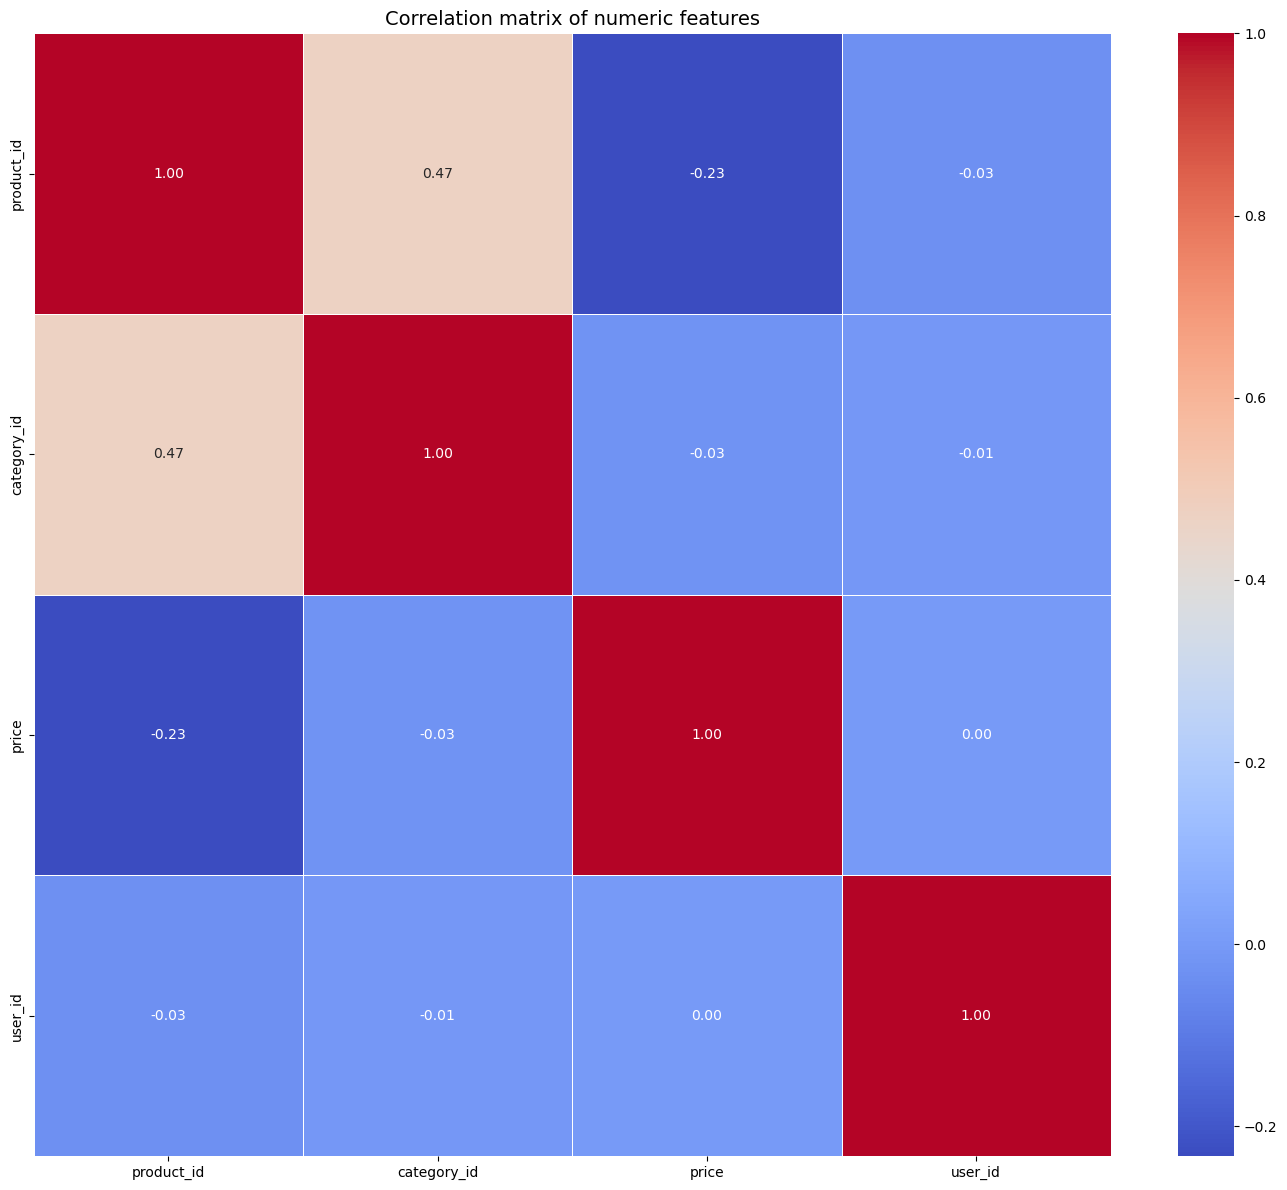

In [27]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

#correlation matrix
corr_matrix = numeric_df.corr()

print("Correlation Matrix (Top 5):")
print(corr_matrix.head())

#Heatmap visualization
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix of numeric features", fontsize=14)
plt.tight_layout()
plt.show()